In [2]:
import json
import urllib.request
from io import StringIO
from html.parser import HTMLParser
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import pylab as pl

# Heading 1

## heading 2

### heading 3
* list1
* list2






In [3]:
#set figure sizes
plt.rcParams["figure.figsize"] = (20,15)

In [4]:
class MLStripper(HTMLParser): #Strips HTML from our downloaded text.  From stackoverflow
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html): #Strips HTML from our downloaded text.  From stackoverflow
    s = MLStripper()
    s.feed(html)
    return s.get_data()

#function to handle the privacy statement count from the json object
#We first check that the index exists then if so, check that the
#count is not a dummy count of -1. If this errors out, we set to 0.
def privacy_stmt_func(json):
    if json:
       try:
           math.sqrt(json[0])
           return json[0]
       except:
           return 0
    else:
        return 0

In [5]:
#initialize needed variables
policy_list = []
policy_dict = {}

#make our subset to flag used applications for MSDS as we come across them
MSDS_use = ['Slack','Kaltura','Microsoft','Google','Youtube','Trello']
MSDS_use_flag = 0

#these data points are sometimes empty, override NoneType error
#with safety net defaults
privacy_stmt_count = 0
policy_text = None

In [12]:
def scrap_policies(start_pg):
    if start_pg == 1:
        cur_pg = 'https://api.usableprivacy.org/websites/'
    elif start_pg <= 1195:
        cur_pg = 'https://api.usableprivacy.org/websites/?page=' + str(start_pg)
    

    #movable testing starting point for faster runtime
    #cur_pg = 'https://api.usableprivacy.org/websites/?page=1195'

    #while loop will continue as long as the page has a 'next' value
    while cur_pg:  
        #pull in our page
        load = json.load(urllib.request.urlopen(cur_pg))
        
        #we have these 6 indices as a pattern on all our API pages
        for i in [0,1,2,3,4,5]:
            
            #reset our varaibles for next policy
            MSDS_use_flag = 0
            policy_dict = {}
            policy_text = None
            privacy_stmt_count = 0

            #use try loop to make sure we keep going and just print out trouble spots in the except
            #reset our flag for next result
            try:
                #code MSDS flag as 1 if we've got something
                if any(name in load['results'][i]['title'] for name in MSDS_use):
                    MSDS_use_flag = 1
                
                #grab the number of privacy statements if possible. 
                privacy_stmt_count = privacy_stmt_func(load['results'][i]['num_privacy_statements'])

                if not(load["results"][i]["fine_grained_policy"]) and load["results"][i]["scraped_policies"]:
                        j = 0
                        policy_text = ""
                        while load["results"][i]["scraped_policies"][0]["segments"][j]["text"]:
                            segment = load["results"][i]["scraped_policies"][0]["segments"][j]["text"]
                            segment = strip_tags(segment)
                            segment = segment.replace("|", "")
                            segment = " ".join(segment.split()) #strip all the extra white space
                            policy_text = policy_text + segment
                            try:
                                n = j+1
                                load["results"][i]["scraped_policies"][0]["segments"][n]["text"]
                                j += 1
                            except:
                                break
                #default to 'No policy text available' if empty
                elif load["results"][i]["fine_grained_policy"]:
                        policy_text = strip_tags(load["results"][i]["fine_grained_policy"]["text"])
                        policy_text = policy_text.replace("|", "")
                        policy_text = " ".join(policy_text.split()) #strip all the extra white space 
                else:
                        policy_text = 'No policy text available'

                #remove any data points we can't use - non-positive word counts
                if load['results'][i]['policy_word_count'] > 0:
                #fill a holder dictionary with all the needed info
                    policy_dict = {'Site URL':load['results'][i]['url'], 'Site Title':load['results'][i]['title'],'Policy Word Count':load['results'][i]['policy_word_count'], 'Privacy Statements Count':privacy_stmt_count, 'MSDS Use Flag':MSDS_use_flag, 'API URL':cur_pg, 'Policy Text':policy_text}
                    #add the dictionary to our list
                    policy_list.append(policy_dict)
                
            #let the loop keep going and just print out where failures occur. This will occur for the last two indicies on the last page since those last slots are empty.
            except:
                print("FAILURE at " + cur_pg + "  index " + str(i))
        
        #Print out progress
        print("SUCCESS for Page " + cur_pg + " loaded")
        #after looping through our results, get the next page. If empty, this breaks our while loop
        cur_pg = load['next']

In [13]:
data_load = input("Do you want to load from the csv? Y/N")
if data_load == "Y":
    policy_df = pd.read_csv("privacy policies.csv")
else:
    pg_num = None
    complete = 0
    while complete == 0:
        try:
            pg_num = int(input("What page do you want to start at? 1-1195"))
            break
        except:
            print("You must input a start page for the scraper.")
    scrap_policies(pg_num)
    #with our complete list, convert it into a dataframe
    policy_df = pd.DataFrame(policy_list)
    #dump into a csv
    policy_df.to_csv('privacy policies.csv')

FAILURE at https://api.usableprivacy.org/websites/?page=1195  index 4
FAILURE at https://api.usableprivacy.org/websites/?page=1195  index 5
SUCCESS for Page https://api.usableprivacy.org/websites/?page=1195 loaded


In [14]:
#store the total number of policies for use
total_count = len(policy_df)
print("There are {} policies downloaded".format(total_count))

There are 4 policies downloaded


In [15]:
#print out our dataframe for an initial look
policy_df

,Site URL,Site Title,Policy Word Count,Privacy Statements Count,MSDS Use Flag,API URL,Policy Text
0,kano.me,kano.me,2810,24,0,https://api.usableprivacy.org/websites/?page=1195,Kano Privacy PolicyPrivacy PolicyLAST UPDATED:...
1,petcube.com,Petcube,6379,62,0,https://api.usableprivacy.org/websites/?page=1195,PRIVACY POLICY This privacy policy V2.2 is eff...
2,www2.meethue.com,Meethue,3021,26,0,https://api.usableprivacy.org/websites/?page=1195,"Privacy Noticefor Customers, Consumers and Oth..."
3,www.runtastic.com,Runtastic,5790,52,0,https://api.usableprivacy.org/websites/?page=1195,PRIVACY POLICYUpdates to Our Privacy Policy At...


In [16]:
#create new calculated column for the estimated read time based on average reading words per minute
policy_df['Read Time(min)'] = round(policy_df['Policy Word Count']/240,2) #average wpm is 240

#check out new column
policy_df

,Site URL,Site Title,Policy Word Count,Privacy Statements Count,MSDS Use Flag,API URL,Policy Text,Read Time(min)
0,kano.me,kano.me,2810,24,0,https://api.usableprivacy.org/websites/?page=1195,Kano Privacy PolicyPrivacy PolicyLAST UPDATED:...,11.71
1,petcube.com,Petcube,6379,62,0,https://api.usableprivacy.org/websites/?page=1195,PRIVACY POLICY This privacy policy V2.2 is eff...,26.58
2,www2.meethue.com,Meethue,3021,26,0,https://api.usableprivacy.org/websites/?page=1195,"Privacy Noticefor Customers, Consumers and Oth...",12.59
3,www.runtastic.com,Runtastic,5790,52,0,https://api.usableprivacy.org/websites/?page=1195,PRIVACY POLICYUpdates to Our Privacy Policy At...,24.12


In [17]:
#store the maximum reading time
max_time = policy_df['Read Time(min)'].max()

policy_df[(policy_df['Read Time(min)']==policy_df['Read Time(min)'].max())]

#print out the policies with the maximum time
policy_df[(policy_df['Read Time(min)']==policy_df['Read Time(min)'].max())]

,Site URL,Site Title,Policy Word Count,Privacy Statements Count,MSDS Use Flag,API URL,Policy Text,Read Time(min)
1,petcube.com,Petcube,6379,62,0,https://api.usableprivacy.org/websites/?page=1195,PRIVACY POLICY This privacy policy V2.2 is eff...,26.58


In [18]:
#which policies are required for our MSDS program
policy_df[(policy_df['MSDS Use Flag']==1)]

,Site URL,Site Title,Policy Word Count,Privacy Statements Count,MSDS Use Flag,API URL,Policy Text,Read Time(min)


In [22]:
#how many minutes would it take to read all the policies required for the MSDS program
print("It would take " + str(round(sum(policy_df[(policy_df['MSDS Use Flag']==1)]['Read Time(min)']),2)) + " minutes (" + str(round(sum(policy_df[(policy_df['MSDS Use Flag']==1)]['Read Time(min)'])/60,2)) + " hours) to read all privacy policies associated with required applications/websites for the MSDS program.")

It would take 38.28 minutes (0.64 hours) to read all privacy policies associated with required applications/websites for the MSDS program.


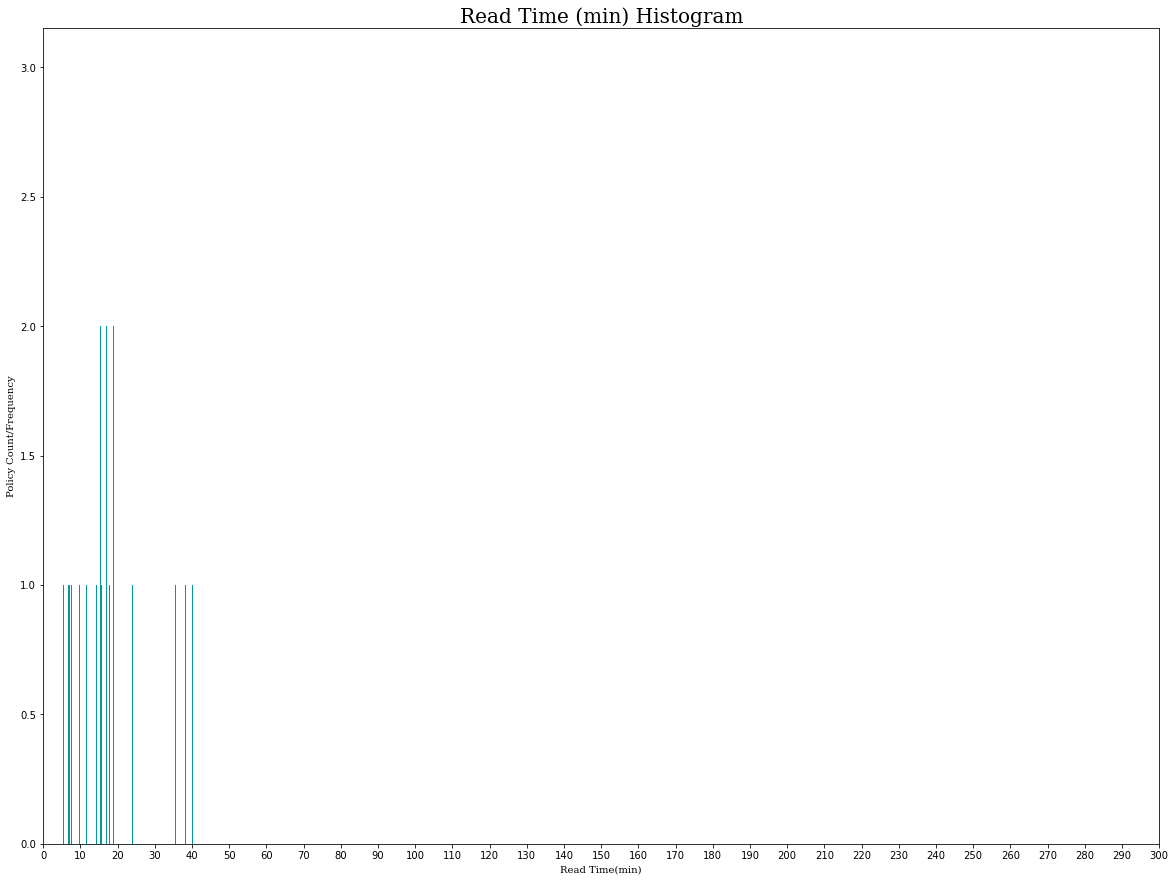

In [24]:
#read_time_hist = policy_df.hist(column='Read Time(min)',grid=False, rwidth=.8, color="#009999", bins=100)
#pl.suptitle("This is Figure title")
read_time_hist = policy_df['Read Time(min)'].plot(kind='hist',sharex=True,sharey=True,title="Read Time (min) Histogram", color="#009999", bins=200,rwidth=.8)
read_time_hist.set_ylabel("Policy Count/Frequency",fontname="serif")
read_time_hist.set_xlabel("Read Time(min)",fontname="serif")
read_time_hist.set_title("Read Time (min) Histogram",fontname="serif",fontsize=20)
read_time_hist.set_xticks(range(0,310,10));
#code to add in a vertical cutoff line
#time_limit = 5
#matplotlib.pyplot.axvline(time_limit,color="k",linestyle="dashed",linewidth=1)
#matplotlib.pyplot.xticks = (range(0,300,20))

In [25]:
read_time_breakdown = pd.DataFrame(policy_df['Read Time(min)'])
read_time_breakdown.columns = ["Read Time"]

#translate read times into buckets
for i in read_time_breakdown["Read Time"].index:
    if read_time_breakdown["Read Time"][i] <= 30:
        read_time_breakdown["Read Time"][i] = math.ceil(read_time_breakdown["Read Time"][i]/5)*5
    elif read_time_breakdown["Read Time"][i] > 30 and read_time_breakdown["Read Time"][i] <= 60:
        read_time_breakdown["Read Time"][i] = 60
    elif read_time_breakdown["Read Time"][i] > 60:
        read_time_breakdown["Read Time"][i] = 61
#rename buckets
read_time_breakdown['Read Time'] = read_time_breakdown['Read Time'].map({5: "0-5min",10:"5-10min",15:"10-15min",20:"15-20min",25:"20-25min",30:"25-30min",60:"30-60min",61:">1hr"})

In [26]:
#Collapse and aggregate read time into buckets, counting the number of policies
read_time_agg = pd.DataFrame({'Read Time':read_time_breakdown['Read Time'].value_counts().index, 'Count':read_time_breakdown['Read Time'].value_counts()})
#Add an additional row for the lowest bucket, which will be empty
read_time_agg = read_time_agg.append({'Read Time':'0min','Count':0},ignore_index=True)
read_time_agg = read_time_agg.set_index('Read Time')
#sort our aggregated dataframe to be in the correct order
read_time_agg = read_time_agg.reindex(["0min","0-5min","5-10min","10-15min","15-20min","20-25min","25-30min","30-60min",">1hr"])

In [27]:
#find and store the maximum reading time in hours, for bucket labeling
max_time_hr = str(math.ceil(max_time/60))

In [28]:
#create a dataframe which holds the count of policies for cumulative buckets
read_time_cumul = pd.DataFrame({'Read Time':["<0min","<5min","<10min","<15min","<20min","<25min","<30min","<1hr","<"+max_time_hr+"hr"],'Cumulative Count':read_time_agg['Count'].cumsum()})
read_time_cumul

,Read Time,Cumulative Count
Read Time,,
0min,<0min,0
0-5min,<5min,1609
5-10min,<10min,3559
10-15min,<15min,5034
15-20min,<20min,5975
20-25min,<25min,6468
25-30min,<30min,6705
30-60min,<1hr,7090
>1hr,<5hr,7166


In [29]:
#repeat for de-cumulative buckets. The above and below dataframes should be exact opposites. The above will start at 0 and accumulate to the total policy count, with buckets defined as "# of policies taking x minutes or less to read". The below will start at the total policy count and decumulate to 0, with buckets defined as "# of policies taking x minutes or more to read".
read_time_cumul_desc = pd.DataFrame({'Read Time':[">0min",">5min",">10min",">15min",">20min",">25min",">30min",">1hr",">"+max_time_hr+"hr"], 'Cumulative Count desc':total_count-read_time_cumul['Cumulative Count']})
read_time_cumul_desc

,Read Time,Cumulative Count desc
Read Time,,
0min,>0min,7166
0-5min,>5min,5557
5-10min,>10min,3607
10-15min,>15min,2132
15-20min,>20min,1191
20-25min,>25min,698
25-30min,>30min,461
30-60min,>1hr,76
>1hr,>5hr,0


In [30]:
#extract out the policy counts from the above dataframes
less_than = read_time_cumul['Cumulative Count']
more_than = read_time_cumul_desc['Cumulative Count desc']

In [34]:
#Combine this data so we can make a stacked bar chart with our series as "Less Than" and "More Than"
read_time_df = pd.DataFrame({'Time Marks':["0min","5min","10min","15min","20min","25min","30min","1hr",max_time_hr+"hr"],"More Than":more_than,"Less Than":less_than})
read_time_df = read_time_df.set_index('Time Marks')
read_time_df

,More Than,Less Than
Time Marks,,
0min,7166,0
5min,5557,1609
10min,3607,3559
15min,2132,5034
20min,1191,5975
25min,698,6468
30min,461,6705
1hr,76,7090
5hr,0,7166


Text(0.5, 1.0, 'How Many Policies Take Less Than/More Than X Minutes to Read?')

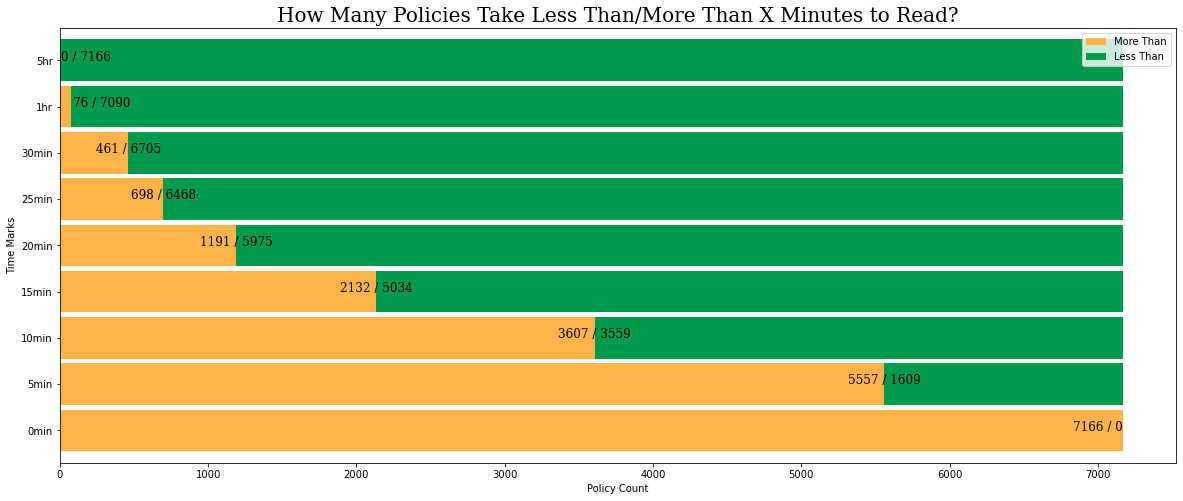

In [42]:
plt.rcParams["figure.figsize"] = (20,8)
#creat a stacked bar chart, all bars totalling to the total policy count, showing how many policies taking more/less than the time cutoffs
rt_barh = read_time_df.plot(kind="barh",stacked=True, width=.9,color=("#fcb44a","#00994d"))

#format chart, put policy counts on each bar
for i,v in enumerate(read_time_df['More Than']):
    if v <100:
        rt_barh.text(v+10,i,str(v)+" / "+str(read_time_df['Less Than'][i]),color="black",fontsize=12,fontname="serif",ha="left")
    elif v == total_count:
        rt_barh.text(v,i,str(v)+" / "+str(read_time_df['Less Than'][i]),color="black",fontsize=12,fontname="serif",ha="right")
    else:
        rt_barh.text(v,i, str(v)+" / "+str(read_time_df['Less Than'][i]),color="black",fontsize=12,fontname="serif",ha="center")
#label the axes and chart
rt_barh.set_xlabel("Policy Count")
rt_barh.set_ylabel("Time Marks")
rt_barh.set_title("How Many Policies Take Less Than/More Than X Minutes to Read?",fontname="serif",fontsize=20)

In [7]:
#take a user input to create a dynamic query based on the user's time cutoff
time_limit = float(input("How much time are you willing to spend reading a privacy policy? Input a time limit in minutes and find out the percentage of policies exceeding it! Input 0 to skip"))
if time_limit > 0:
    policy_count = len(policy_df[(policy_df['Read Time(min)']>time_limit)])
    print("There are {} policies which take the average person at least {} minutes to read".format(policy_count,time_limit))
    print("The percentage of all policies exceeding this time limit is {}%.".format(round((policy_count/total_count)*100),4))

user_time_df = pd.DataFrame({"More Than":[policy_count],"Less Than":[total_count-policy_count]})

plt.rcParams["figure.figsize"] = (20,1)
#creat a stacked bar chart, all bars totalling to the total policy count, showing how many policies taking more/less than the time cutoffs
rt_barh = user_time_df.plot(kind="barh",stacked=True, width=.9,color=("#fcb44a","#00994d"))

#format chart, put policy counts on each bar
for i,v in enumerate(user_time_df['More Than']):
    if v <100:
        rt_barh.text(v+10,i,str(v)+" / "+str(user_time_df['Less Than'][i]),color="black",fontsize=12,fontname="serif",ha="left")
    elif v == total_count:
        rt_barh.text(v,i,str(v)+" / "+str(user_time_df['Less Than'][i]),color="black",fontsize=12,fontname="serif",ha="right")
    else:
        rt_barh.text(v,i, str(v)+" / "+str(user_time_df['Less Than'][i]),color="black",fontsize=12,fontname="serif",ha="center")
#label the axes and chart
rt_barh.set_xlabel("Policy Count")
rt_barh.set_ylabel("Time Marks")
rt_barh.set_title("How Many Policies Take Less Than/More Than {} Minutes to Read?".format(time_limit),fontname="serif",fontsize=20)

NameError: name 'policy_df' is not defined

In [28]:
#provide an input for the user to export privacy policies associated to a company
company_name = input("Which company policy would you like to export? Note that some companies may have multiple policies. Input N to skip")
file_name = input("What should the file name be? Input N for default")
if company_name != "N":
    company_policies = policy_df[(policy_df['Site Title']==company_name)][['Site Title','Policy Text']]
    
    if file_name == "N":
        curdatetime = dt.datetime.now().isoformat(timespec='seconds').replace(':','')
        file_name = company_name + "privacypolicies" + curdatetime
    
    file_name = file_name + ".csv"
    
    if len(company_policies) == 0:
        print("No policies on file for {}".format(company_name))
    else:
        company_policies.to_csv(file_name)
        if len(company_policies) > 1:
            print("We exported {} policies for {} to file {}.".format(len(company_policies),company_name,file_name))
        else:
            print("We exported 1 policy for {} to file {}.".format(company_name,file_name))
        

No policies on file for sdfblkjh
